In [1]:
import numpy as np
import sympy
from sympy import *
print("Using sympy version", sympy.__version__)
init_session(quiet=True)
s_I0, s_xi, s_mu, s_sigma, s_amp, s_beta, s_alpha = \
    symbols(r'I_0 \xi \mu \sigma A \beta \alpha')

Using sympy version 1.3



In [2]:
%matplotlib inline

In [28]:
%config InlineBackend.figure_format='retina'

In [3]:
import matplotlib.pyplot as plt

In [14]:
def _I(N=10):
    """
    Return the Nth order approximation to the shifted
    spectrum as a SymPy expression.
    
    """
    # The rest frame line profile
    s_I0 = 1 - s_amp * exp(-Rational(1, 2) * (s_xi - s_mu) ** 2 / s_sigma ** 2)
    
    # The higher order terms
    SN = 0
    for n in range(1, N + 1):
        SN += (-1) ** n / factorial(n) * diff(s_I0, s_xi, n) * s_alpha ** n
    
    # Return
    return s_I0 + SN

In [15]:
def I(lam, alpha=0, mu=0.0, sigma=0.1, amp=1.0, N=10):
    """
    Return the shifted spectrum as a numpy array,
    computed using the Taylor expansion.
    
    """
    if alpha == 0:
        N = 0    
    args = (s_xi, s_mu, s_sigma, s_amp, s_alpha)
    return lambdify(args, _I(N=N), "numpy")(
                xi, mu, sigma, amp, alpha
            )

In [26]:
def I_num(xi, alpha=0, mu=0.0, sigma=0.1, amp=1.0, npts=1000):
    """
    Return the disk-integrated spectrum as a numpy array,
    computed numerically.
    
    """
    # The rest frame line profile
    I0 = 1 - amp * np.exp(-0.5 * (xi - mu) ** 2 / sigma ** 2)
    xi0 = xi - alpha
    return np.interp(xi0, xi, I0)

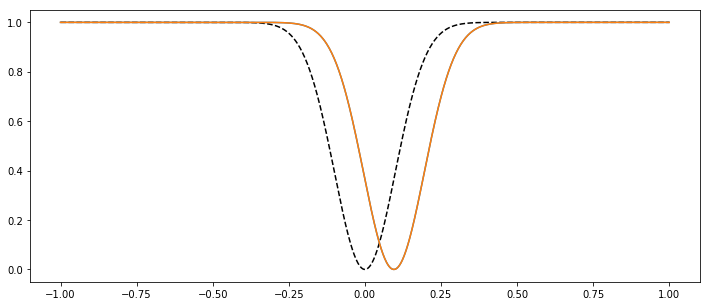

In [20]:
xi = np.linspace(-1, 1, 1000)
beta = 0.1
alpha = np.log(1 + beta)
figure = plt.figure(figsize=(12, 5))
plt.plot(xi, I(xi, alpha=0), 'k--');
plt.plot(xi, I_num(xi, alpha=alpha), 'C0');
plt.plot(xi, I(xi, alpha=alpha, N=12), 'C1');

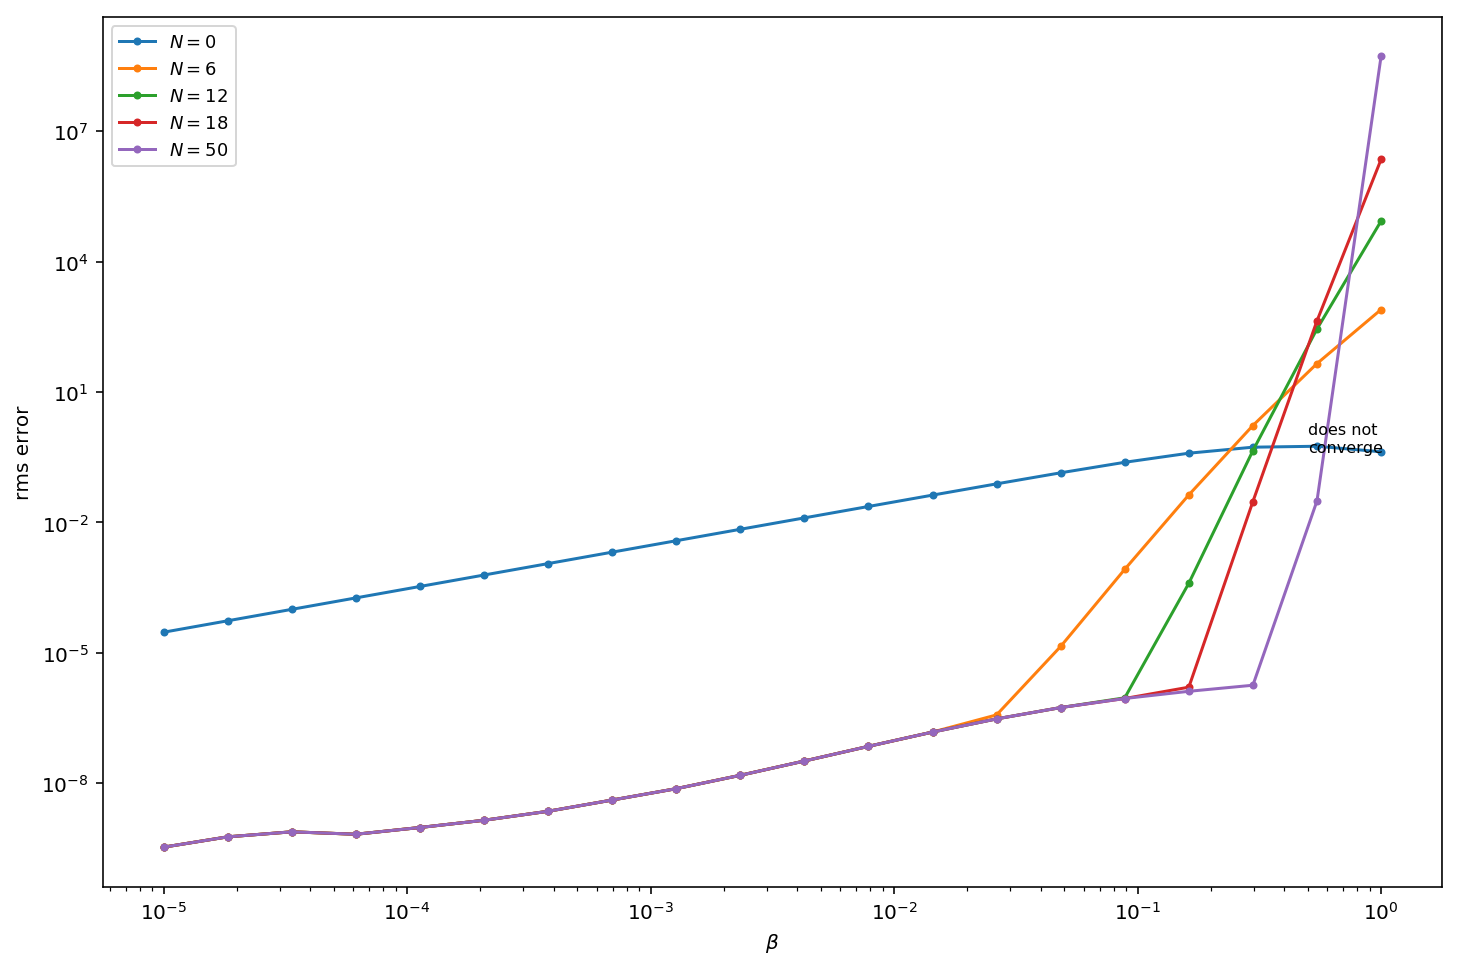

In [32]:
mu = 0
sigma = 0.1
npts = 1000
xi = np.linspace(mu - 5 * sigma, mu + 5 * sigma, npts)
xi_hr = np.linspace(mu - 5 * sigma, mu + 5 * sigma, npts * 100)
N_arr = list(np.arange(0, 30, 6))
N_arr[-1] = 50
beta_arr = np.logspace(-5, 0, 20)
rms = np.zeros((len(N_arr), len(beta_arr)))
for i, beta in enumerate(beta_arr):
    alpha = np.log(1 + beta)
    true_I_hr = I_num(xi_hr, alpha=alpha, sigma=sigma)
    true_I = np.interp(xi, xi_hr, true_I_hr)
    for j, N in enumerate(N_arr):
        rms[j, i] = np.sqrt(np.mean((I(xi, alpha=alpha, N=N, sigma=sigma) 
                                     - true_I) ** 2))

fig = plt.figure(figsize=(12, 8))
for j, N in enumerate(N_arr):
    plt.plot(beta_arr, rms[j], '.-', 
             label=r"$N = {0}$".format(N))
plt.yscale("log")
plt.xscale("log")
plt.legend(fontsize=9)
plt.ylabel("rms error")
plt.xlabel(r"$\beta$")
plt.gca().set_xlim(*plt.gca().get_xlim())
plt.axvspan(3, plt.gca().get_xlim()[1], color="k", alpha=0.2)
plt.annotate("does not \nconverge", xy=(0.9, 0.5), 
             xycoords="axes fraction", fontsize=8);